In [1]:
import os
import sys
import pickle
import argparse
from scipy import sparse, io 
import numpy as np
import rpy2.robjects as robjects
import magic
import scprep
from sklearn.decomposition import NMF, non_negative_factorization, PCA
from sklearn.decomposition._nmf import _beta_divergence
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix 


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *
from findK_correction_constd_jk import *

import pdb

np.random.seed(123)

In [2]:
Yfile = "../../ebpmf_data_analysis/output/fastTopics_fit/sla_small.txt"
datafile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_fitted.Rds"
vocabfile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_vocab.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"
exper_step1 = "findK-exper-step1.pkl"
exper_step2 = "findK-exper-step2.pkl"

## load data and fitted L, F, s
Y = io.mmread(Yfile)
vocab = np.loadtxt(vocabfile, dtype = str)
readRDS = robjects.r['readRDS']
data = readRDS(datafile)
w_idx = np.asarray(data.rx2('word_idx')).astype(int)
fitted = data.rx2('fit_sub')
F = np.asarray(fitted.rx2('F'))
L = np.asarray(fitted.rx2('L'))
s = np.asarray(fitted.rx2('s'))
p, k = F.shape
n = L.shape[0]

C = L @ F.T
C = C.T @ C / n
Cbar = C / C.sum(axis = 1)[:, None]
w_true = C.sum(axis = 1)


In [3]:
def get_truth(Cbar, K):
    p = Cbar.shape[0]
    U = np.zeros((p, K))
    R = Cbar.T
    S = np.zeros(K)
    gs = np.zeros((p, K))
    g = (R**2).sum(axis = 0) 
    for k in range(K):
        gs[:, k] = g
        maxSquaredSum = np.max(g)
        maxCol = np.argmax(g)
        S[k] = maxCol
        u = R[:, maxCol].copy()
        u = u / np.sqrt(maxSquaredSum)
        U[:, k] = u
        R = R -  u[:, None] @ (u[:,None].T @ R)
        dg = (Cbar @ u)**2
        g -= dg        

    return S, U, gs

S, U, gs = get_truth(Cbar, k)
S

array([1669., 1888.,  178., 1666.,  490., 1933.])

In [4]:
outputfile="findK-exper-constd-jk.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

est = tmp['est']
se = tmp['se']


gs_sc = gs * np.power(w_true, 2)[:, None]
est_sc = est * np.power(w_true, 2)[:, None, None]
se_sc = se * np.power(w_true, 2)[:, None, None]

In [6]:
def comparison(k_, gs, est, se):
    
    truth = gs[:, k_]
    est_ = est[:, k_,:].mean(axis = 1)

    fig, ax = plt.subplots(1)
    ax.scatter(truth, est_)
    plt.xlim((truth.min(), truth.max()))
    plt.ylim((est_.min(), est_.max()))
    plt.xlabel("g_truth")
    plt.ylabel("g_est") 


    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.show()
    
    se_emp = np.sqrt(((est[:, k_, :] - est_[:, None])**2).mean(axis = 1))
    se_ = se[:, k_, :].mean(axis = 1)
    
    

    fig, ax = plt.subplots(1)
    ax.scatter(se_emp, se_)
    plt.xlim((se_emp.min(), se_emp.max()))
    plt.ylim((se_.min(), se_.max()))

    plt.xlabel("se_truth")
    plt.ylabel("se_est") 


    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.show()

step 0


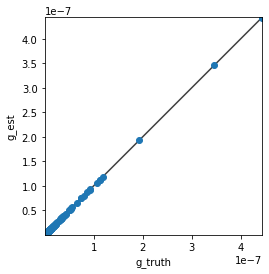

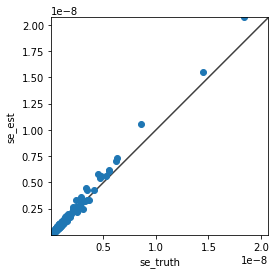

step 1


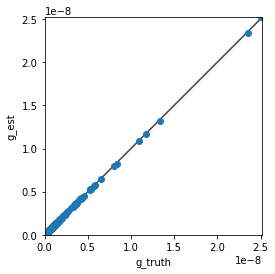

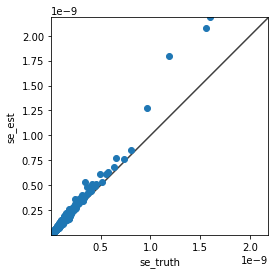

step 2


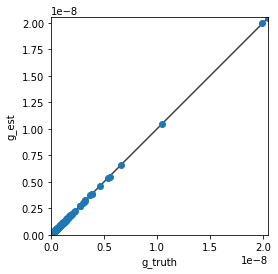

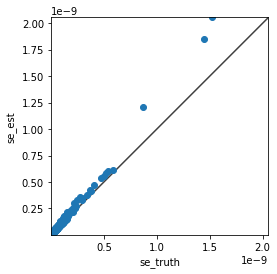

step 3


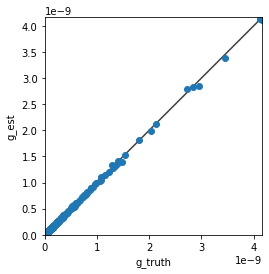

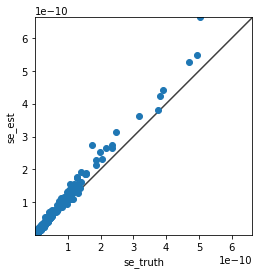

step 4


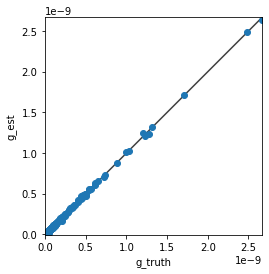

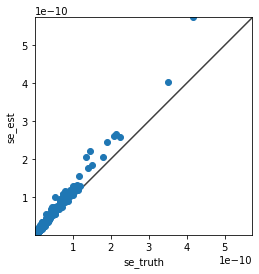

step 5


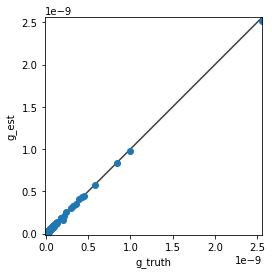

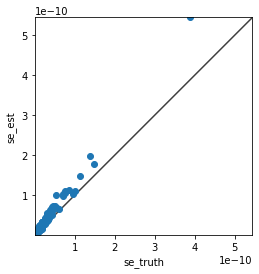

In [10]:
for k_ in range(k):
    print(f"step {k_}")
    comparison(k_, gs_sc.copy(), est_sc.copy(), se_sc.copy())

step 0


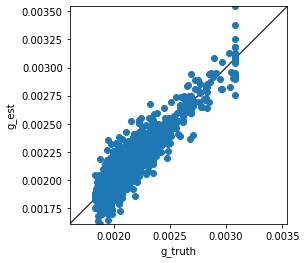

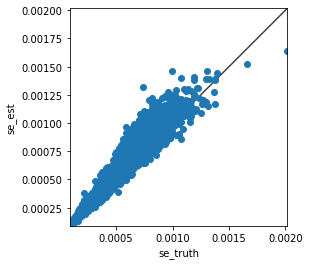

step 1


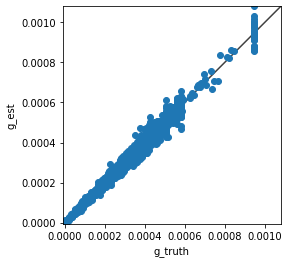

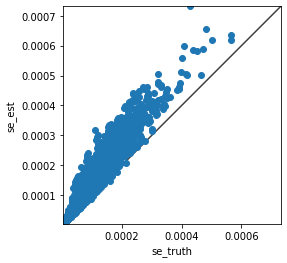

step 2


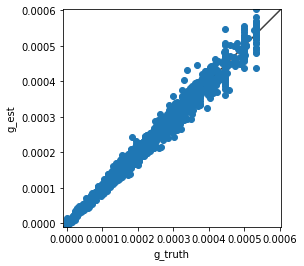

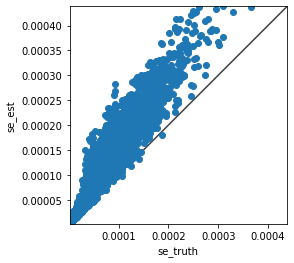

step 3


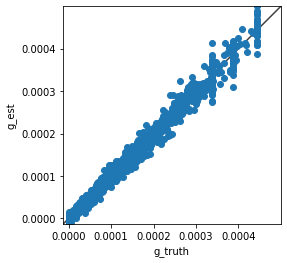

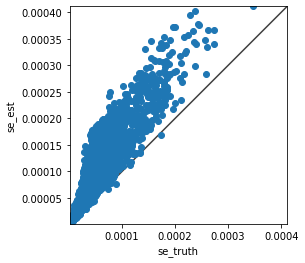

step 4


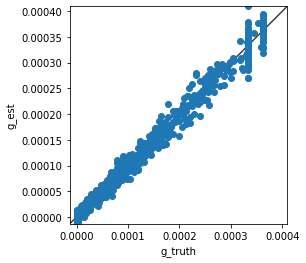

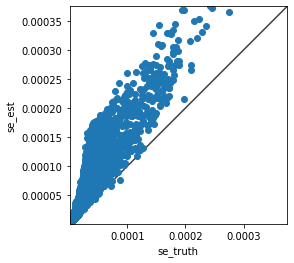

step 5


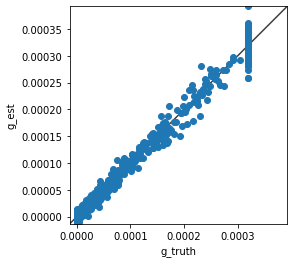

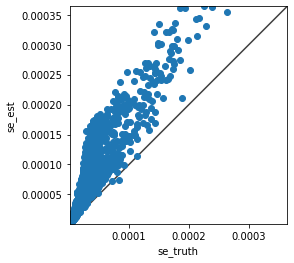

In [11]:
for k_ in range(k):
    print(f"step {k_}")
    comparison(k_, gs.copy(), est.copy(), se.copy())

## use unknown $w$

step 0


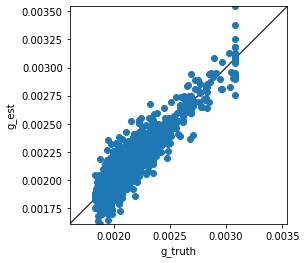

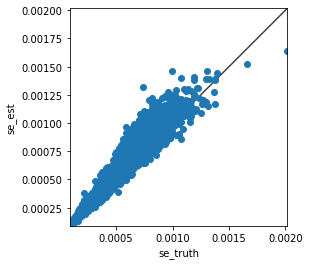

step 1


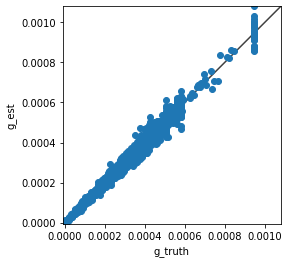

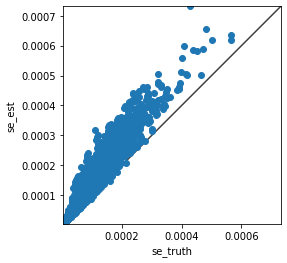

step 2


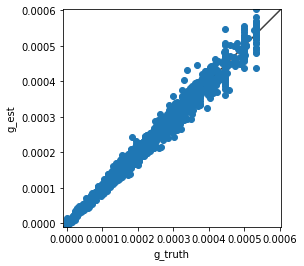

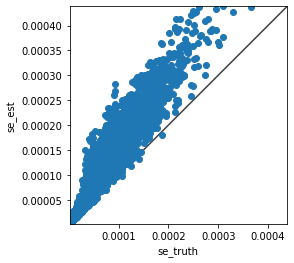

step 3


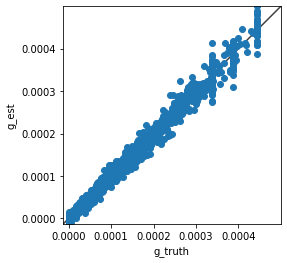

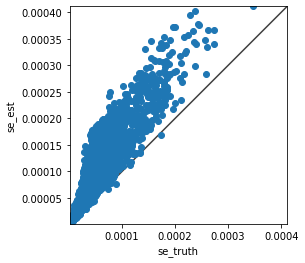

step 4


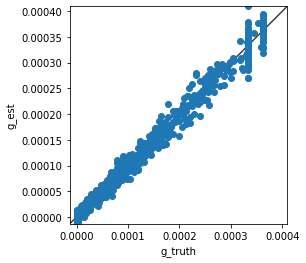

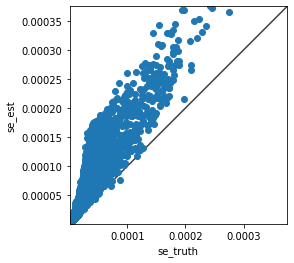

step 5


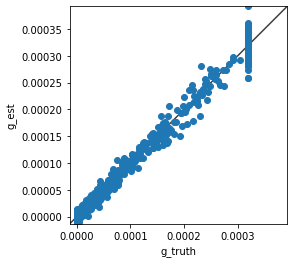

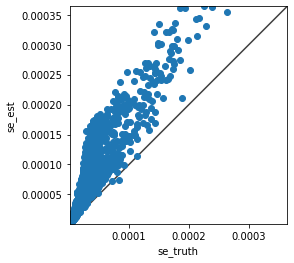

In [12]:
outputfile="findK-exper-constd-jk.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

est_unknown_w = tmp['est']
se_unknown_w = tmp['se']

for k_ in range(k):
    print(f"step {k_}")
    comparison(k_, gs.copy(), est_unknown_w.copy(), se_unknown_w.copy())